In [162]:
#Importing the Libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler,PowerTransformer
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
import lightgbm as lgb
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [163]:
df = pd.read_csv("./data_thuchanh.csv", encoding="latin-1", sep=';')

In [164]:
feats= ['4']

In [165]:
from sklearn.preprocessing import StandardScaler
transformer = StandardScaler()
X=transformer.fit_transform(np.array(df[feats]).reshape(-1,1))


In [166]:
BGM = BayesianGaussianMixture(n_components=7,covariance_type='full',random_state=1,n_init=15)
preds = BGM.fit_predict(X)
df["Clusters"]= preds

In [167]:
pp=BGM.predict_proba(X)
df_new=pd.DataFrame(X,columns=feats)
df_new[[f'predict_proba_{i}' for i in range(7)]]=pp
df_new['preds']=preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)

train_index=np.array([])
for n in range(7):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

In [168]:
#ricopue's notebook's code snippet
from sklearn.model_selection import StratifiedKFold
X_new=df_new.loc[train_index][feats]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.1,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':7}

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx],feature_name = feats)
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx],feature_name = feats)

    model = lgb.train(params = params_lgb,
                train_set = tr_dataset,
                valid_sets =  vl_dataset,
                num_boost_round = 5000,
                callbacks=[ lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(period=200)])

    model_list.append(model)

[200]	valid_0's multi_logloss: 0.000281905
[200]	valid_0's multi_logloss: 0.000291984
[200]	valid_0's multi_logloss: 0.000267879
[200]	valid_0's multi_logloss: 0.000165331
[400]	valid_0's multi_logloss: 0.000165034
[600]	valid_0's multi_logloss: 0.000164946
[800]	valid_0's multi_logloss: 0.000164905
[1000]	valid_0's multi_logloss: 0.000164881
[1200]	valid_0's multi_logloss: 0.000164866
[1400]	valid_0's multi_logloss: 0.000164855
[1600]	valid_0's multi_logloss: 0.000164847
[1800]	valid_0's multi_logloss: 0.000164841
[2000]	valid_0's multi_logloss: 0.000164836
[2200]	valid_0's multi_logloss: 0.000164832
[2400]	valid_0's multi_logloss: 0.000164828
[2600]	valid_0's multi_logloss: 0.000164826
[2800]	valid_0's multi_logloss: 0.000164823
[3000]	valid_0's multi_logloss: 0.000164821
[3200]	valid_0's multi_logloss: 0.00016482
[3400]	valid_0's multi_logloss: 0.000164818
[3600]	valid_0's multi_logloss: 0.000164817
[3800]	valid_0's multi_logloss: 0.000164815
[4000]	valid_0's multi_logloss: 0.000164

In [169]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new[feats])

In [170]:
labels=np.argmax(lgb_preds,axis=1)

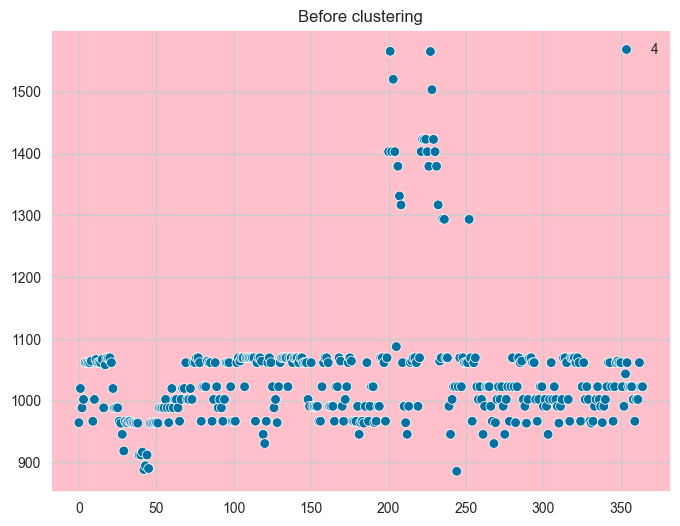

In [171]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(label="bla")
sns.scatterplot(df[feats], marker='o');
ax.set_title("Before clustering");

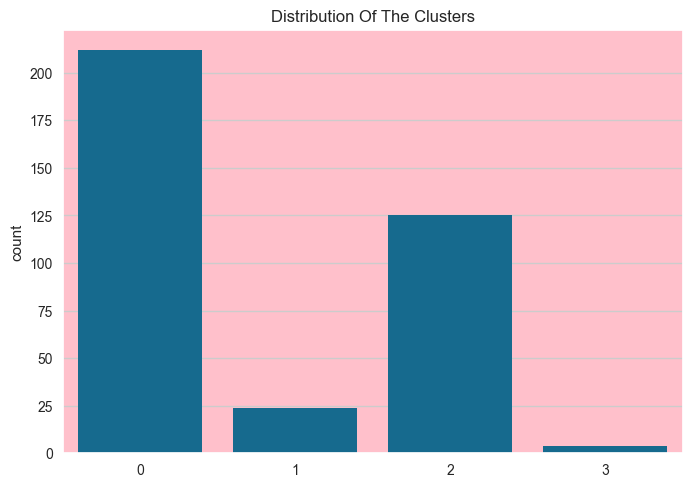

In [172]:
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Distribution Of The Clusters")
plt.show()

## Xay dung mo hinh LSTM

In [173]:
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

In [174]:
df['Ngày'] = pd.to_datetime(df['Ngày'], format='%d/%m/%Y')
df.sort_values(by='Ngày', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [175]:
test_size = df[df['Ngày'].dt.month==12].shape[0]
test_size

31

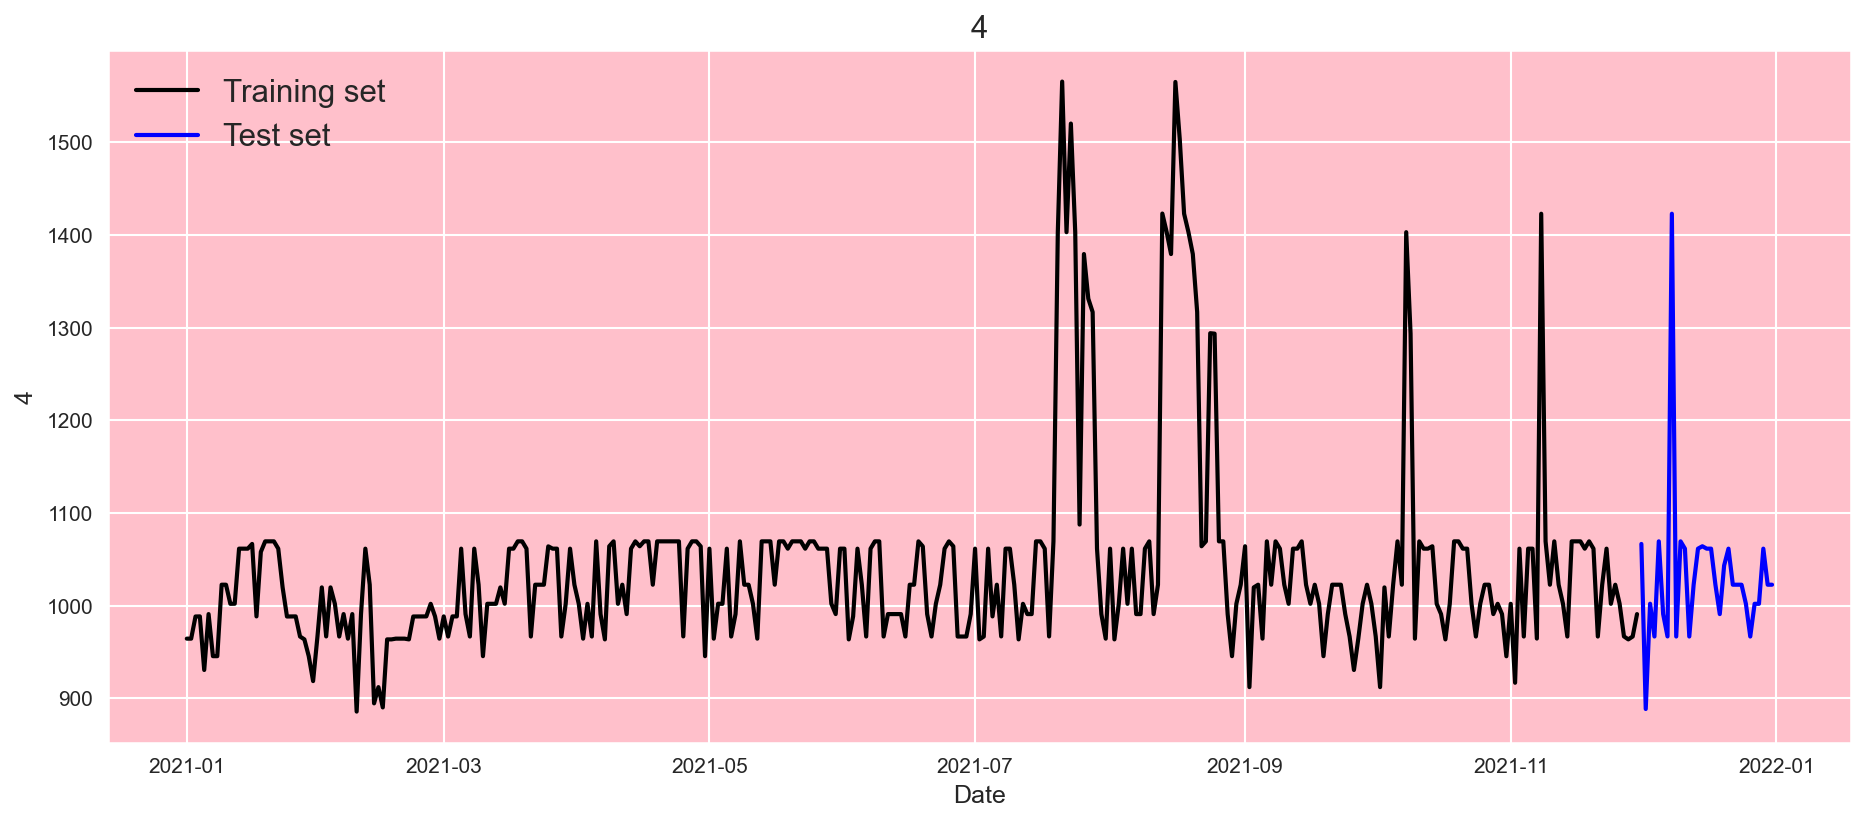

In [176]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'pink'
plt.rc('axes',edgecolor='white')
plt.plot(df['Ngày'][:-test_size], df['4'][:-test_size], color='black', lw=2)
plt.plot(df['Ngày'][-test_size:], df['4'][-test_size:], color='blue', lw=2)
plt.title('4', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('4', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [177]:
import plotly.express as px
fig = px.line(y=df['4'], x=df['Ngày'])
fig.update_traces(line_color='black')
fig.update_layout(xaxis_title="Ngày",
                  yaxis_title="4",
                  title={'text': "Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='pink')

In [178]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df['4'].values.reshape(-1,1))

MinMaxScaler()

In [179]:
window_size = 15

In [180]:
train_data = df['4'][:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [181]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])

In [182]:
test_data = df['4'][-test_size-window_size:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [183]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, 0])
    y_test.append(test_data[i, 0])

In [184]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [185]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [186]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64)(input1)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()

    return model

In [187]:
model = define_model()
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 15, 1)]           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                16896     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 19009 (74.25 KB)
Trainable params: 19009 (74.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
18/18 [==============================] - 4s 41ms/step - loss: 0.1140 - val_loss: 0.0562
Epoch 2/100
18/18 [==============================] - 0s

In [188]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 418ms/step


In [189]:
from sklearn.metrics import mean_absolute_percentage_error,accuracy_score,r2_score
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1-MAPE

In [190]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.020600615069270134
Test MAPE: 1.830170357388251
Test Accuracy: -0.8301703573882511


In [191]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

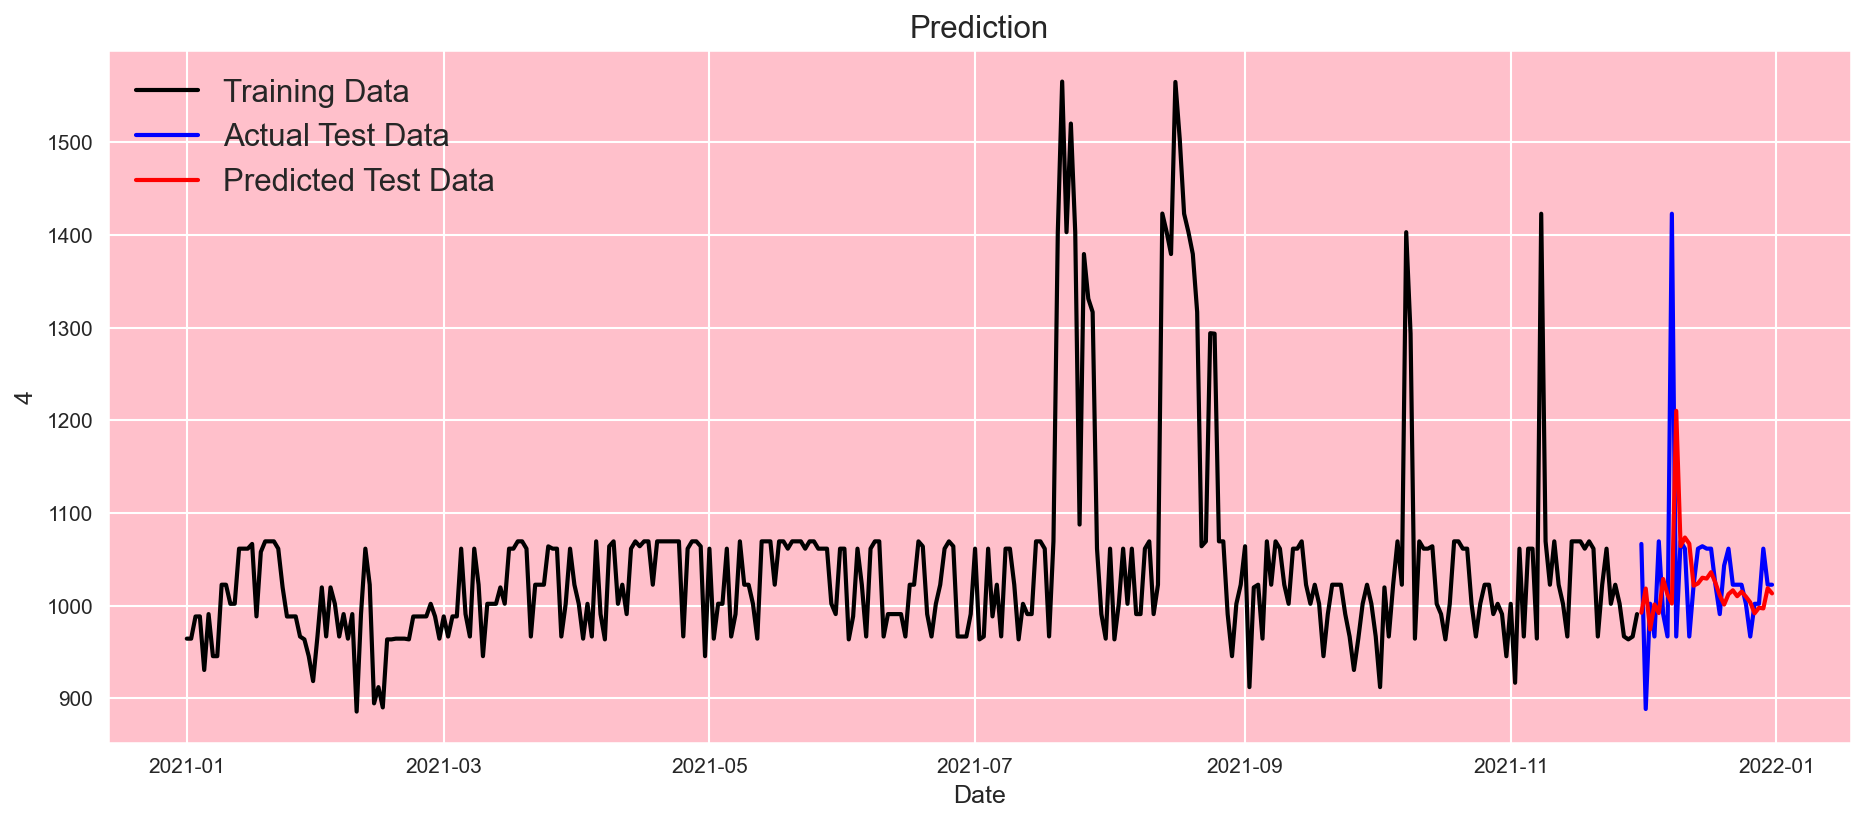

In [192]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'pink'
plt.rc('axes',edgecolor='white')
plt.plot(df['Ngày'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Ngày'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Ngày'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('4', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()